In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import numpy as np
import pickle
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [ ]:
image_path = "/content/drive/MyDrive/Colab Notebooks/flickr_data/Images"
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/flickr_data/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20 , 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [ ]:
import re
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'[^a-z]', ' ', x))
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'\s+', ' ', x))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    data['caption'] = "startseq " + data['caption'] + " endseq"
    return data

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

In [ ]:
images = data['image'].unique().tolist()
nimages = len(images)

train_split = int(0.7 * nimages)
val_split   = int(0.85 * nimages)

train_images = images[:train_split]
val_images   = images[train_split:val_split]
test_images  = images[val_split:]

train = data[data['image'].isin(train_images)]
val   = data[data['image'].isin(val_images)]
test  = data[data['image'].isin(test_images)]

train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 313, 63, 194, 116, 2]

In [ ]:
import pickle

# حفظ الـ tokenizer في ملف
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
model = DenseNet201(weights="imagenet")
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


100%|██████████| 8091/8091 [1:30:20<00:00,  1.49it/s]


In [ ]:
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features, shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y


In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)

sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

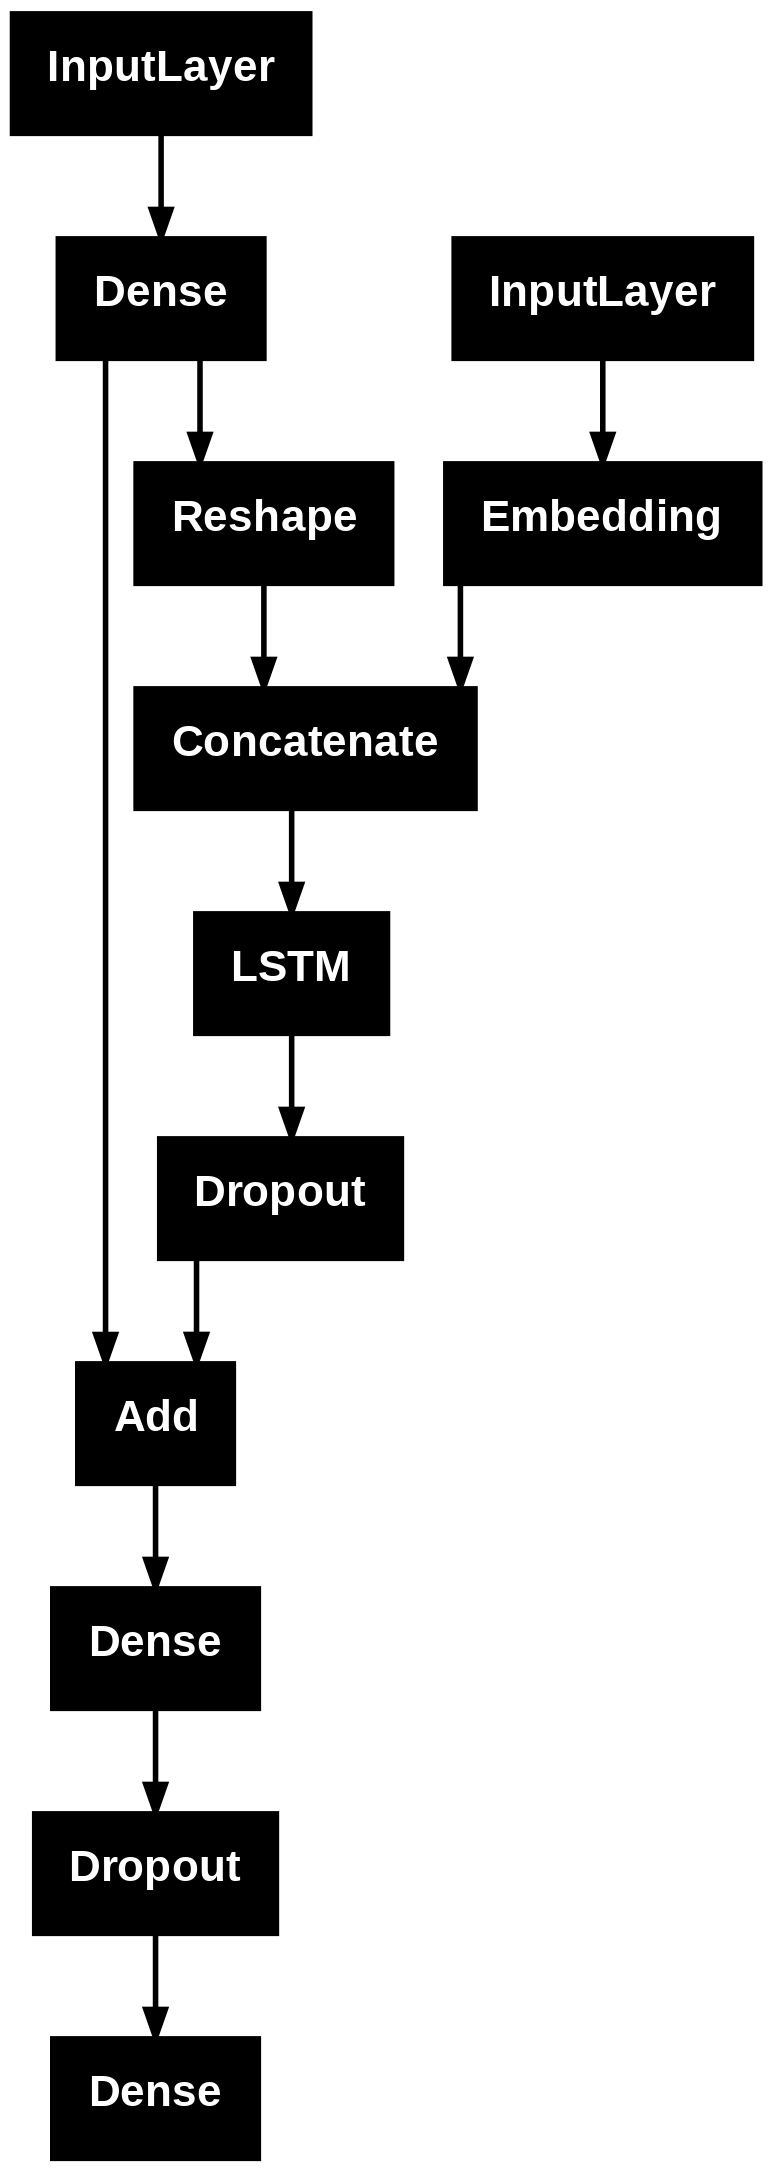

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model)

In [ ]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 256)   │  2,157,312 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 36, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8427)      │  1,087,083 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,294,379 (16.38 MB)

 Trainable params: 4,294,379 (16.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_generator = CustomDataGenerator(train, 'image', 'caption', 64,
                                      image_path, tokenizer, vocab_size,
                                      max_length, features)

val_generator = CustomDataGenerator(val, 'image', 'caption', 64,
                                    image_path, tokenizer, vocab_size,
                                    max_length, features)

test_generator = CustomDataGenerator(test, 'image', 'caption', 64,
                                     image_path, tokenizer, vocab_size,
                                     max_length, features, shuffle=False)

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min",
                             save_best_only=True, verbose=1)

earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1,
                              restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2,
                                            verbose=1, factor=0.2, min_lr=1e-8)

In [ ]:
history = caption_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)

Epoch 1/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1246 - loss: 5.7883
Epoch 1: val_loss improved from inf to 4.51024, saving model to model.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 966s 2s/step - accuracy: 0.1247 - loss: 5.7869 - val_accuracy: 0.2263 - val_loss: 4.5102 - learning_rate: 0.0010
Epoch 2/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2365 - loss: 4.3891
Epoch 2: val_loss improved from 4.51024 to 4.16955, saving model to model.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 959s 2s/step - accuracy: 0.2365 - loss: 4.3890 - val_accuracy: 0.2632 - val_loss: 4.1696 - learning_rate: 0.0010
Epoch 3/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2645 - loss: 4.0550
Epoch 3: val_loss improved from 4.16955 to 4.01511, saving model to model.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 951s 2s/step - accuracy: 0.2645 - loss: 4.0549 - val_accuracy: 0.2754 - val_loss: 4.0151 - learning_rate: 0.0010
Epoch 4/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2786 - loss: 3.8434
Epoch 4: val_loss improved from 4.01511 to 3.94099, saving model to model.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 944s 2s/step - accuracy: 0.2786 - loss: 3.8434 - val_accuracy: 0.2821 - val_loss: 3.9410 - learning_rate: 0.0010
Epoch 5/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2886 - loss: 3.7094
Epoch 5: val_loss improved from 3.94099 to 3.88202, saving model to model.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 935s 2s/step - accuracy: 0.2886 - loss: 3.7094 - val_accuracy: 0.2915 - val_loss: 3.8820 - learning_rate: 0.0010
Epoch 6/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2987 - loss: 3.5943
Epoch 6: val_loss improved from 3.88202 to 3.84884, saving model to model.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 951s 2s/step - accuracy: 0.2987 - loss: 3.5943 - val_accuracy: 0.2966 - val_loss: 3.8488 - learning_rate: 0.0010
Epoch 7/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3056 - loss: 3.5077
Epoch 7: val_loss improved from 3.84884 to 3.83422, saving model to model.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 943s 2s/step - accuracy: 0.3056 - loss: 3.5077 - val_accuracy: 0.3021 - val_loss: 3.8342 - learning_rate: 0.0010
Epoch 8/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3109 - loss: 3.4233
Epoch 8: val_loss improved from 3.83422 to 3.82300, saving model to model.h5


442/442 ━━━━━━━━━━━━━━━━━━━━ 938s 2s/step - accuracy: 0.3109 - loss: 3.4233 - val_accuracy: 0.3031 - val_loss: 3.8230 - learning_rate: 0.0010
Epoch 9/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3130 - loss: 3.3762
Epoch 9: val_loss did not improve from 3.82300
442/442 ━━━━━━━━━━━━━━━━━━━━ 935s 2s/step - accuracy: 0.3130 - loss: 3.3762 - val_accuracy: 0.3059 - val_loss: 3.8310 - learning_rate: 0.0010
Epoch 10/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3196 - loss: 3.3113
Epoch 10: val_loss did not improve from 3.82300

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
442/442 ━━━━━━━━━━━━━━━━━━━━ 947s 2s/step - accuracy: 0.3196 - loss: 3.3113 - val_accuracy: 0.3052 - val_loss: 3.8446 - learning_rate: 0.0010
Epoch 11/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3281 - loss: 3.2175
Epoch 11: val_loss did not improve from 3.82300
442/442 ━━━━━━━━━━━━━━━━━━━━ 937s 2s/step - accuracy: 0.3281 - loss: 3.2174 - val_accuracy: 0.3

In [ ]:
test_loss, test_acc = caption_model.evaluate(test_generator)
print(f"🔹 Test Accuracy: {test_acc:.4f}")
print(f"🔹 Test Loss: {test_loss:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 407s 4s/step - accuracy: 0.3087 - loss: 3.7012
🔹 Test Accuracy: 0.3132
🔹 Test Loss: 3.6759


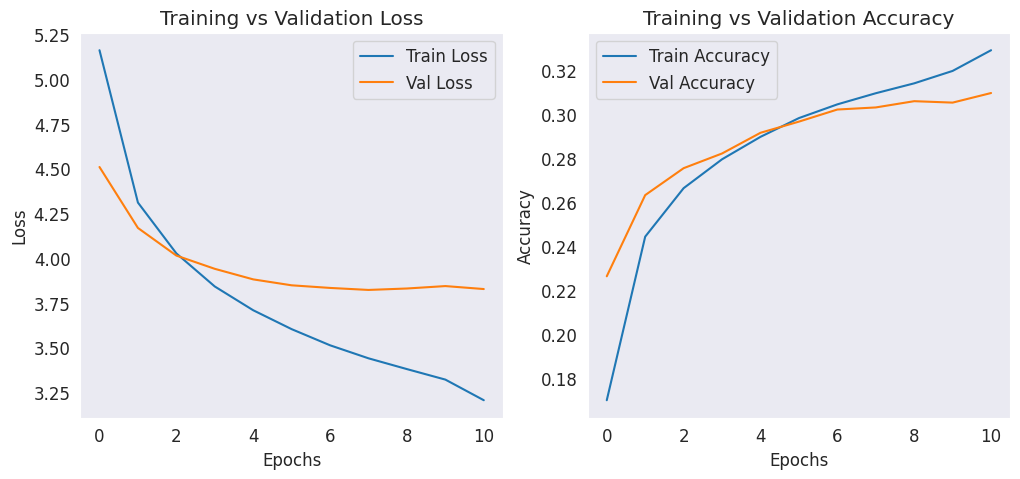

In [ ]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat, None)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text.replace('startseq', '').replace('endseq', '').strip()

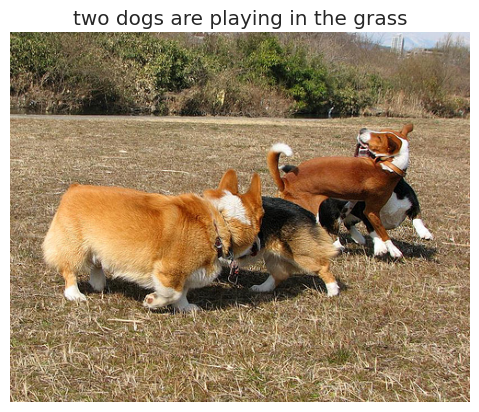

In [ ]:
img_path = "/content/drive/MyDrive/Colab Notebooks/flickr_data/Images/439492931_a96d590e40.jpg"
img = load_img(img_path, target_size=(img_size, img_size))
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)
feature = fe.predict(img, verbose=0)

caption = generate_caption(caption_model, tokenizer, feature, max_length)
plt.imshow(load_img(img_path))
plt.axis("off")
plt.title(caption)
plt.show()

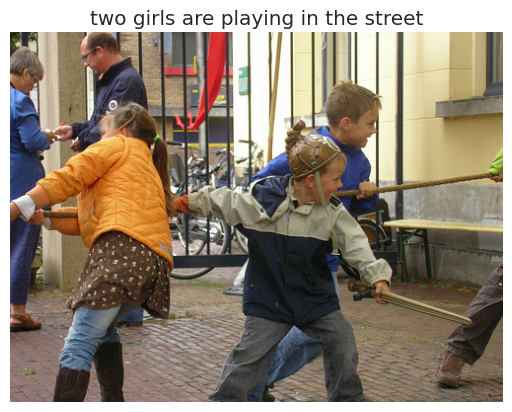

In [ ]:
img_path = "/content/drive/MyDrive/Colab Notebooks/flickr_data/Images/494907021_321e82877a.jpg"   # استبدل باسم صورة من test
img = load_img(img_path, target_size=(img_size, img_size))
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)
feature = fe.predict(img, verbose=0)

caption = generate_caption(caption_model, tokenizer, feature, max_length)
plt.imshow(load_img(img_path))
plt.axis("off")
plt.title(caption)
plt.show()

In [ ]:
# تحميل النموذج المدرب
model = load_model('model.h5')

# تحميل tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)